In [26]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
import sqlalchemy
import sqlite3
import os
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [27]:
os.getcwd()
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles'
os.chdir(new_path)

# Applying SQL to Movies

In this notebook I show you how I run and use **SQL** through special engines in **Python** to manage large databases & insightfully answer questions with additional analysis through libraries (Plotly, Seaborn, sk-learn). 

#### Why `SQL` with a  `Python` engine?

I will be running my queries using `Python` engines **SQLAlchemy** & **SQLite** in absence of a DMBS. 

I use a combination of the two engines in a **sandboxed workflow** because debugging is easier with `%sql` magic. After I've found the proper query, I like to copy it over to the `pd.read_sql` command for visualization, modeling, and export with Pandas, sklearn, and other Python libraries. This is a worklow I learned at UC Berkeley's Advanced Data Science Principles course, **Data 100**.

### The Data: IMDb Movie Database

To apply SQL, I will be using a subset of [IMDb's Movie Database](https://www.imdb.com). The year range is 1902-2021.



#### SQLite connection

In [28]:
conn = sqlite3.connect('imdbmini.db')

In [29]:
#load
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [30]:
%sql sqlite:///imdbmini.db

## SQLAlchemy connection

In [31]:
sqlite_conn = 'sqlite:///imdbmini.db'

In [32]:
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

## Preview of the Total IMDB Database 

In [33]:
%%sql 
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


There are 4 tables in this database: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click for Table Schema</b>] See descriptions of each table's data.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- averageRating (real) – weighted average of all the individual user ratings
- numVotes (integer) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- year (YYYY) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>

From the above descriptions, we can conclude:
* `Name.nconst` and `Title.tconst` are **primary keys** of the `Name` and `Title` tables, respectively.
* that `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

### Previewing the Title table
What kind of information exists regarding movie titles in this database?

In [34]:
%%sql
SELECT * FROM Title
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy"
4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War"
10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery"
12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family"
13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror"


### What can we learn from the Titles dataset? 

**How far back does the data go for movies?**

In [37]:
%%sql
SELECT primaryTitle, startYear, titleType
FROM Title
WHERE startYear IS NOT NULL AND titleType IS 'movie'
ORDER BY startYear
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


primaryTitle,startYear,titleType
The Birth of a Nation,1915,movie
The Cabinet of Dr. Caligari,1920,movie
The Kid,1921,movie
Nosferatu,1922,movie
Sherlock Jr.,1924,movie
Battleship Potemkin,1925,movie
The Gold Rush,1925,movie
The General,1926,movie
Metropolis,1927,movie
Sunrise,1927,movie


**What are the distribution of movies premiering each year?**

In [42]:
query_ydist = """
SELECT startYear, COUNT(*) AS total
FROM Title
WHERE startYear IS NOT NULL AND titleType IS 'movie'
GROUP BY startYear;
"""

res_ydist = pd.read_sql(query_ydist, engine)
res_ydist

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


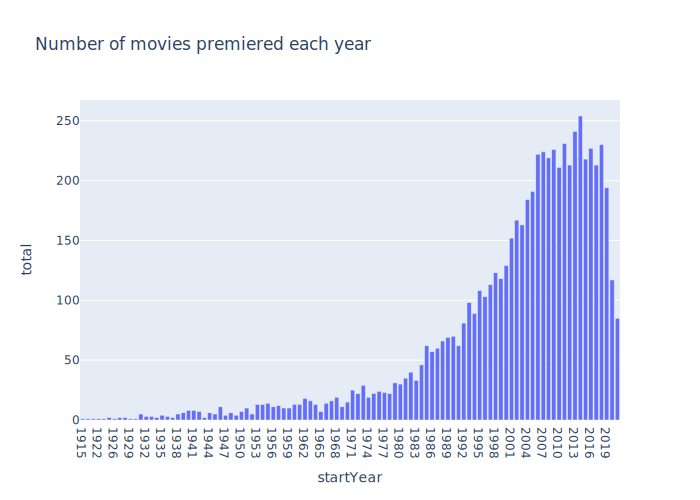

In [45]:
fig = px.bar(res_ydist, x="startYear", y="total", title="Number of movies premiered each year")
fig.show(renderer="svg")

**Who are the most prolific actors/actresses?**

In [48]:
%%sql
SELECT primaryName AS name, COUNT(*) AS total
FROM Name
INNER JOIN Role ON Name.nconst = Role.nconst
INNER JOIN Title ON Title.tconst = Role.tconst
WHERE (category = "actor" OR category = "actress") AND titleType = "movie"
GROUP BY primaryName
ORDER BY total DESC
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


name,total
Robert De Niro,64
Samuel L. Jackson,54
Nicolas Cage,53
Bruce Willis,49
Tom Hanks,46
Johnny Depp,43
Mark Wahlberg,41
Morgan Freeman,40
Liam Neeson,40
Sylvester Stallone,39


**What are the top 10 highest rated movies?**

In [49]:
%%sql
SELECT primaryTitle AS title, 
    CAST(Rating.numVotes AS int) AS numVotes, 
    averageRating
FROM Rating
JOIN Title
ON Rating.tconst = Title.tconst
ORDER BY numVotes DESC
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


title,numVotes,averageRating
The Shawshank Redemption,2462686,9.3
The Dark Knight,2417875,9.0
Inception,2169255,8.8
Fight Club,1939312,8.8
Pulp Fiction,1907561,8.9
Forrest Gump,1903969,8.8
Game of Thrones,1874040,9.2
The Matrix,1756469,8.7
The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
The Lord of the Rings: The Return of the King,1709023,8.9


### What about Harry Potter Movies ? 
#### How many movies, when were they made, how long are they?

FYI: I do NOT consider "Fantastic Beasts" as belonging with Harry Potter...

In [50]:
%%sql
SELECT tconst AS id,
    titleType, 
    primaryTitle AS movieName, 
    startYear AS yearMade, 
    runtimeMinutes FROM Title
WHERE primaryTitle LIKE '%Harry%' AND primaryTitle LIKE '%Potter%';

 * sqlite:///imdbmini.db
Done.


id,titleType,movieName,yearMade,runtimeMinutes
241527,movie,Harry Potter and the Sorcerer's Stone,2001,152
295297,movie,Harry Potter and the Chamber of Secrets,2002,161
304141,movie,Harry Potter and the Prisoner of Azkaban,2004,142
330373,movie,Harry Potter and the Goblet of Fire,2005,157
373889,movie,Harry Potter and the Order of the Phoenix,2007,138
417741,movie,Harry Potter and the Half-Blood Prince,2009,153
926084,movie,Harry Potter and the Deathly Hallows: Part 1,2010,146
1201607,movie,Harry Potter and the Deathly Hallows: Part 2,2011,130


### Im going to deep-dive into my favorite genre:  Sci-Fi Drama 

### problem:
The genres column applies multiple genres to every movie. This makes it ***really hard*** to specify a unique singular genre type as every unique instance of a list of genres is "distinct". 

In [147]:
%%sql
SELECT DISTINCT genres
FROM Title
WHERE titleType = "movie"
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


genres
"Drama,History,War"
"Fantasy,Horror,Mystery"
"Comedy,Drama,Family"
"Fantasy,Horror"
"Action,Comedy,Romance"


In [148]:
%%sql genre_sql <<
SELECT * FROM Title;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable genre_sql


In [149]:
genre_df = genre_sql.DataFrame()

#pythonically
#genre_list = []
#genre_list = [word for sentence in genre_df["genres"].str.split(",") 
#                  for word in sentence 
#                      if word not in genre_list]
#genre_list

#iteratively
genres_list = []
type(genre_df["genres"][0])

for i in genre_df["genres"].str.split(","):
    for j in i:
        if j not in genres_list: 
            genres_list.append(j)

genres_list

['Action',
 'Adventure',
 'Comedy',
 'Drama',
 'History',
 'War',
 'Fantasy',
 'Horror',
 'Mystery',
 'Family',
 'Romance',
 'Thriller',
 'Sci-Fi',
 'Biography',
 'Documentary',
 'Music',
 'Short',
 'Crime',
 'Musical',
 'Animation',
 'Film-Noir',
 'Western',
 'Sport',
 'News',
 'Talk-Show',
 'Game-Show',
 'Reality-TV']

Now I have a list of genres names to work with.

### new problem: most movies are tagged as having multiple genres, skewing results of individual genres

In [150]:
%%sql
SELECT genres, COUNT(*) AS count
FROM Title
WHERE genres NOT LIKE "%,%" AND titleType = "movie"
GROUP BY genres
ORDER BY count DESC;

 * sqlite:///imdbmini.db
Done.


genres,count
Drama,209
Comedy,181
Horror,52
Documentary,16
Thriller,7
Western,4
Action,3


Im going to now explore the data accounting for the fact that multiple genres are tagged.

#### What are the top-rated Sci-Drama movies of all time (within range)? 

In [168]:
%%sql 
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  genres,
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Sci-Fi%" AND genres LIKE "%DRAMA%"
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,title,titleType,genres,year,rating,numRatings
816692,Interstellar,movie,"Adventure,Drama,Sci-Fi",2014,8.6,1613897
482571,The Prestige,movie,"Drama,Mystery,Sci-Fi",2006,8.5,1244379
434409,V for Vendetta,movie,"Action,Drama,Sci-Fi",2005,8.1,1065965
338013,Eternal Sunshine of the Spotless Mind,movie,"Drama,Romance,Sci-Fi",2004,8.3,948018
3659388,The Martian,movie,"Adventure,Drama,Sci-Fi",2015,8.0,794444


### As of today (2024) the ratings have changed! 
Remember this dataset was collected from 2021, so I've accounted for that in this [IMDB](https://www.imdb.com/search/title/?title_type=feature&genres=sci-fi,drama&release_date=,2022-01-01&sort=num_votes,desc) search. But naturally, 3 years of additional ratings have shifted things.

It looks like "Avengers: Endgame" has gone up to 3rd place, shifting  "V for Vendetta", "Eternal Sunshine of the Spotless Mind" & "The Martian" down.

<center>
<img alt="top5scidrammoves" src="top5scidram.png" width="500px;" />
</center>

### Diving deeper into Sci-Fi Dramas

#### Im going to convert this into a Python dataframe so that I can explore it a bit more

In [176]:
%%sql sdram_movies_sql <<
SELECT T.tconst AS id,
  CAST(startYear AS int) AS year,
  primaryTitle AS title, 
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Sci-Fi%" AND genres LIKE "%Drama%"
ORDER BY numRatings DESC;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable sdram_movies_sql


In [177]:
sdram_df = sdram_movies_sql.DataFrame()
sdram_df.head()

,id,year,title,rating,numRatings
0,816692,2014,Interstellar,8.6,1613897
1,482571,2006,The Prestige,8.5,1244379
2,434409,2005,V for Vendetta,8.1,1065965
3,338013,2004,Eternal Sunshine of the Spotless Mind,8.3,948018
4,3659388,2015,The Martian,8.0,794444


### Average Ratings for Sci-Fi Drama movies across time

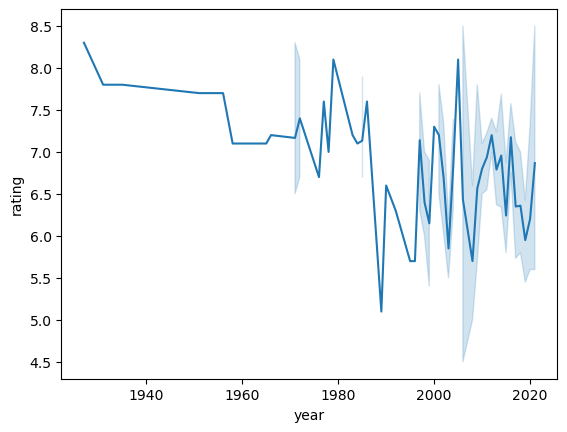

In [178]:
sns.lineplot(data=sdram_df, x="year", y="rating");

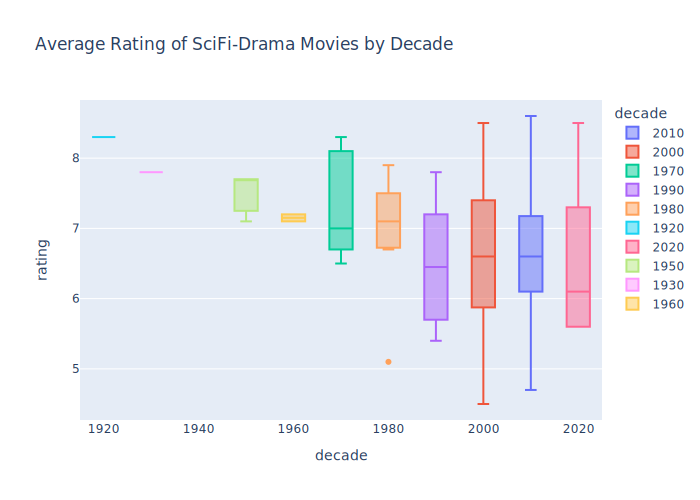

In [179]:
sdram_df['decade'] = (sdram_df['year'] // 10) * 10
fig = px.box(sdram_df, x = 'decade', y = 'rating', color = "decade", title=
      "Average Rating of SciFi-Drama Movies by Decade")

fig.show(renderer="svg")

### What can we find out about the first spike right before the 1980s?


Which **category** of **Sci-Fi movies** have the highest average ratings across all the movies in the 1970s-1980s? 

$$
\text{genreRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

In [211]:
%%sql

SELECT genres AS genre, SUM((averageRating)*numVotes)/SUM(numVotes) AS genreRating
FROM Name
INNER JOIN Role ON Name.nconst = Role.nconst
INNER JOIN Title ON Title.tconst = Role.tconst
INNER JOIN Rating ON Title.tconst = Rating.tconst
WHERE titleType = "movie"
    AND genre LIKE "%Sci-Fi%"
    AND CAST(numVotes AS int) > 1000
    AND (startYear <= 1990 AND startYear > 1979)
GROUP BY genre
HAVING COUNT(*) >= 20 
ORDER BY genreRating DESC
LIMIT 5; 


 * sqlite:///imdbmini.db
Done.


genre,genreRating
"Adventure,Comedy,Sci-Fi",8.018474245661494
"Horror,Mystery,Sci-Fi",7.772254822084093
"Drama,Sci-Fi",7.690089284360835
"Action,Sci-Fi,Thriller",7.608723900675974
"Action,Adventure,Sci-Fi",7.438070955960294


### It seems like the 80s preferred Adventure / Comedy Sci-Fi
#### What were they watching?



In [212]:
%%sql 
SELECT T.tconst AS id,
    startYear AS year,
    primaryTitle AS title,
    genres,
    averageRating,
    numVotes
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE titleType = "movie"
      AND startYear <= 1990 AND startYear > 1979
      AND genres LIKE "%Sci-Fi%"     
ORDER BY averageRating DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,year,title,genres,averageRating,numVotes
88763,1985,Back to the Future,"Adventure,Comedy,Sci-Fi",8.5,1112320
90605,1986,Aliens,"Action,Adventure,Sci-Fi",8.3,678152
83658,1982,Blade Runner,"Action,Sci-Fi,Thriller",8.1,721364
84787,1982,The Thing,"Horror,Mystery,Sci-Fi",8.1,390752
88247,1984,The Terminator,"Action,Sci-Fi",8.0,820648


### How does this compare to genres of the 80s ? 

In [232]:
%%sql 
SELECT genres AS genre, SUM((averageRating)*numVotes)/SUM(numVotes) AS genreRating
FROM Name
INNER JOIN Role ON Name.nconst = Role.nconst
INNER JOIN Title ON Title.tconst = Role.tconst
INNER JOIN Rating ON Title.tconst = Rating.tconst
WHERE titleType = "movie"
    AND CAST(numVotes AS int) > 1000
    AND (startYear <= 1990 AND startYear > 1979)
GROUP BY genre
HAVING COUNT(*) >= 20 
ORDER BY genreRating DESC
LIMIT 5; 

 * sqlite:///imdbmini.db
Done.


genre,genreRating
"Biography,Crime,Drama",8.647548818814863
"Drama,Horror",8.330405368695358
"Drama,War",8.158557477117057
"Adventure,Drama",8.100000000000001
"Action,Adventure,Fantasy",8.058857547263708


In [233]:
%%sql  
SELECT T.tconst AS id,
 CAST(startYear AS int) AS year,
  primaryTitle AS title,
  genres,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE (year <= 1990 AND year > 1979)
      AND titleType = "movie"
      AND genres LIKE "%Drama%" 
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,year,title,genres,rating,numRatings
99685,1990,Goodfellas,"Biography,Crime,Drama",8.7,1069422
81505,1980,The Shining,"Drama,Horror",8.4,941780
86250,1983,Scarface,"Crime,Drama",8.3,777942
93058,1987,Full Metal Jacket,"Drama,War",8.3,701160
95953,1988,Rain Man,Drama,8.0,489908


In [234]:
%%sql  rom_movies_sql <<
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  CAST(runtimeMinutes AS int) AS time,  
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE time > 0 AND -- get rid of outliers and missing values --
      year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Romance%"
ORDER BY numRatings DESC;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable rom_movies_sql


### A Last look into genres over time: Romance is dead

In [245]:
rom_df = rom_movies_sql.DataFrame()
rom_df.head()

,id,title,titleType,time,year,rating,numRatings
0,109830,Forrest Gump,movie,142,1994,8.8,1903969
1,120338,Titanic,movie,194,1997,7.8,1091853
2,338013,Eternal Sunshine of the Spotless Mind,movie,108,2004,8.3,948018
3,119217,Good Will Hunting,movie,126,1997,8.3,900171
4,1010048,Slumdog Millionaire,movie,120,2008,8.0,817735


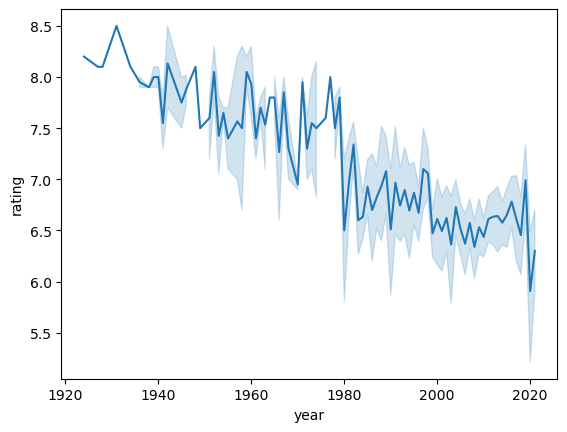

In [246]:
sns.lineplot(data=rom_df, x="year", y="rating");

 ## WIP: PCA & Clustering

### Classifying movies into a genre based on decade

In [247]:
%%sql pca_pre_sql <<
SELECT *
FROM Title 
JOIN Rating ON Title.tconst = Rating.tconst;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable pca_pre_sql


In [248]:
pca_df = pca_pre_sql.DataFrame()
pca_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst,averageRating,numVotes
0,417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy",417,8.2,46382
1,4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War",4972,6.3,23836
2,10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery",10323,8.1,60244
3,12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family",12349,8.3,120059
4,13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror",13442,7.9,92218
